# Projet Gustave Malachane Kilian Violet

In [2]:
!py -m pip install requests

In [3]:
import urllib.request
import json
import pandas as pd
import requests
import shutil
import os

def download_image(url, name):

    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        with open("./images/"+name+".jpg", "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code


url = "https://query.wikidata.org/sparql?query=Select%20%3Fvolcan%20%3Fimage%20%3Flabel_pays%20%3Fhauteur%20%3Flabel%20%7B%0A%20%20%3Fvolcan%20wdt%3AP31%20wd%3AQ169358%3B%0A%20%20%20%20%20%20%20%20wdt%3AP18%20%3Fimage%3B%0A%20%20%20%20%20%20%20%20wdt%3AP17%20%3Fpays%3B%0A%20%20%20%20%20%20%20%20wdt%3AP2660%20%3Fhauteur%3B%0A%20%20%20%20%20%20%20%20rdfs%3Alabel%20%3Flabel.%0A%20%20%0A%20%20%3Fpays%20rdfs%3Alabel%20%3Flabel_pays.%0A%20%20%0A%20%20FILTER(lang(%3Flabel)%3D%22en%22%20%26%26%20lang(%3Flabel_pays)%3D%22en%22)%0A%7D%0A%0ALIMIT%20150&format=json"
response = urllib.request.urlopen(url)
responsedata = json.loads(response.read().decode("utf-8"))

array = []
metadata_list = []
i = 1
for data in responsedata["results"]["bindings"]:

    metadata = {
        "nom": data["label"]["value"],
        "hauteur": data["hauteur"]["value"],
        "pays": data["label_pays"]["value"]            
    }

    metadata_list.append(metadata)
    response = download_image(str(data["image"]["value"]).replace("%20", "_").replace("%C3%A1", "a"), metadata["nom"])
    
    i += 1
    
dataframe = pd.DataFrame(array, columns=["label", "image"])

with open("metadata.json", "w", encoding="utf-8") as json_file:
    json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)

## Récupération des données exifs des images

Ici grâce à la librairie PIL & exifread, nous pouvons accéder aux données exifs de l'image. elles sont ensuite stockées dans le fichier JSON metadata.json

In [4]:
!py -m pip install exifread

In [5]:
import os
import json
from PIL import Image
import exifread
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image


def get_dominant_colors(image_path, k=5):
    """ Extrait les k couleurs dominantes d'une image avec K-Means """
    with Image.open(image_path) as img:
        img = img.resize((100, 100))  # Réduire la taille pour accélérer le clustering
        img_array = np.array(img).reshape(-1, 3)  # Convertir en tableau de pixels

    # Clustering des couleurs
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(img_array)

    # Convertir les couleurs en hexadécimal
    colors = ['#%02x%02x%02x' % tuple(map(int, color)) for color in kmeans.cluster_centers_]
    return colors

# Dossier contenant les images
image_folder = "images"

# Parcourir chaque fichier image
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    try:
        # Ouvrir l'image avec PIL
        with Image.open(image_path) as img:
            width, height = img.size
            format_img = img.format

            colors = get_dominant_colors(image_path)

            # Déterminer l'orientation
            if width > height:
                orientation = "Paysage"
            elif height > width:
                orientation = "Portrait"
            else:
                orientation = "Carré"

        # Lire les métadonnées EXIF
        with open(image_path, "rb") as img_file:
            tags = exifread.process_file(img_file, details=False)
            date_creation = tags.get("EXIF DateTimeOriginal", "Inconnu")
            camera_model = tags.get("Image Model", "Inconnu")

        # Stocker les métadonnées dans un dictionnaire
        metadataIndex = next((i for i, md in enumerate(metadata_list) if md["nom"]+".jpg" == image_name), -1)
        
        exif = {
            "nom": image_name,
            "chemin": image_path,
            "taille": f"{width}x{height}",
            "format": format_img,
            "orientation": orientation,
            "annee_capture": str(date_creation)[:4],
            "date_creation": str(date_creation),
            "modele_camera": str(camera_model),
            "colors": colors,
        }

        metadata_list[metadataIndex]["image"] = exif

    except Exception as e:
        print(f"⚠️ Erreur avec {image_name} : {e}")

# Sauvegarder les métadonnées en JSON
with open("metadata.json", "w", encoding="utf-8") as json_file:
    json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)

print("\n Métadonnées enregistrées dans metadata.json")


⚠️ Erreur avec Mount Ragang.jpg : Image size (768777555 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

 Métadonnées enregistrées dans metadata.json


In [6]:
import json
import random

# Charger les volcans depuis un fichier JSON
with open("metadata.json", "r", encoding="utf-8") as f:
    volcans = json.load(f)

# Vérifier le nombre total de volcans
nombre_total_volcans = len(volcans)
print(f"Nombre total de volcans chargés : {nombre_total_volcans}")

# Génération de 50 utilisateurs fictifs
utilisateurs = [
    {"id": i, "nom": f"Utilisateur_{i}", "volcans_consultés": []}
    for i in range(1, 51)
]

# Attribution aléatoire des volcans consultés (en enregistrant uniquement le nom)
for utilisateur in utilisateurs:
    nb_volcans = random.randint(5, 20)  # Chaque utilisateur consulte entre 5 et 20 volcans
    volcans_choisis = random.sample(volcans, min(nb_volcans, nombre_total_volcans))
    
    # Stocker uniquement le nom des volcans
    utilisateur["volcans_consultés"] = [volcan["nom"] for volcan in volcans_choisis]

# Sauvegarde des données dans un fichier JSON
with open("utilisateurs_volcans.json", "w", encoding="utf-8") as f:
    json.dump(utilisateurs, f, indent=4, ensure_ascii=False)

# Affichage d'un aperçu des 5 premiers utilisateurs
print(json.dumps(utilisateurs[:5], indent=4, ensure_ascii=False))  # Afficher les 5 premiers utilisateurs


Nombre total de volcans chargés : 130
[
    {
        "id": 1,
        "nom": "Utilisateur_1",
        "volcans_consultés": [
            "Mount Kazbek",
            "Mount Apo",
            "Rinjani",
            "Mount Baker",
            "Llaima",
            "Ollagüe",
            "Mount Pelée",
            "Sinarka",
            "Acotango"
        ]
    },
    {
        "id": 2,
        "nom": "Utilisateur_2",
        "volcans_consultés": [
            "Acotango",
            "Antisana volcano",
            "Cabalian Volcano",
            "Pyroclastic Peak",
            "Ollagüe",
            "Mount Rainier",
            "Mount Baker",
            "Mount Iō"
        ]
    },
    {
        "id": 3,
        "nom": "Utilisateur_3",
        "volcans_consultés": [
            "Camiguin de Babuyanes",
            "Ollagüe",
            "Ulawun",
            "Mount Shari",
            "Koryaksky",
            "Mount Kazbek",
            "Iztaccihuatl",
            "Mount Iō",
           

# Visualisation des données

Dans cette partie nous allons étudier toutes les données que nous avons récupérées grâce à des graphiques tracées avec la librairie matplotlib. 

c:\Users\viole\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Text(0.5, 0.5, 'count')

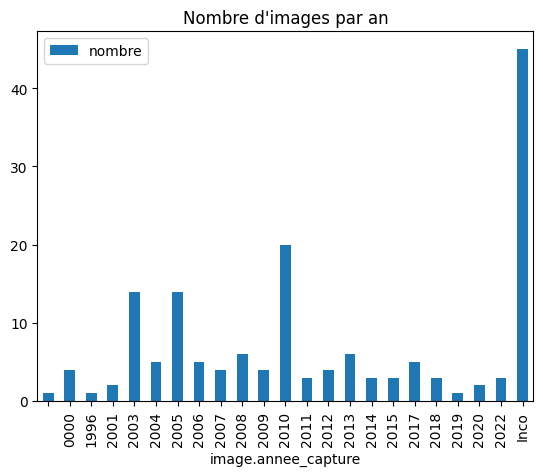

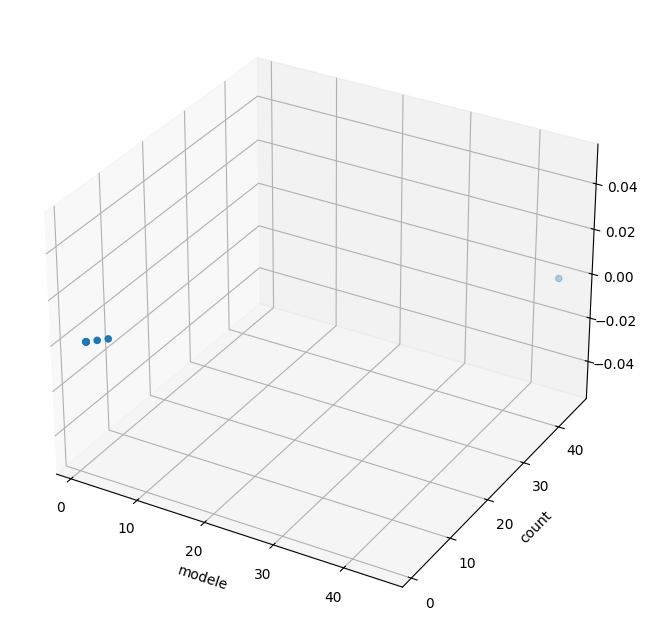

In [42]:
import matplotlib.pyplot as plot
from pandas import json_normalize
import json
import numpy
import math
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import scale, minmax_scale


# Graphe proportion des volcans par pays
data = json.load(open("metadata.json", encoding="utf8"))
data_normalized = pd.DataFrame(json_normalize(data), columns=["pays", "nom"]) 
data_normalized = data_normalized.astype(
    dtype={"pays": "<U200", "nom": "<U200"}
)

grouped = data_normalized.groupby("pays").count()
grouped = grouped.rename(columns={"nom": "nombre"}).reset_index()
grouped.plot(x=0, kind="bar", title="proportion de volcans par pays")


# Nombre d'image disponible pour chaque année 
data2_normalized = pd.DataFrame(json_normalize(data, max_level=1), columns=["image.annee_capture", "nom"])

annee_capture = data2_normalized["image.annee_capture"]

grouped2 = annee_capture.value_counts().sort_index()
grouped2.plot(x=0, kind="bar", title="Nombre d'images par an")

# Le nombre d'images disponibles pour les différents types : taille de l'image, l'orientation des images, les modèles d'appareils photo, etc. 

cluster_count = 1
array = []
for element in data:
    if "image" in element:
        if 'nom' in element["image"] and 'orientation' in element["image"] and 'taille' in element["image"] and 'modele_camera' in element["image"]: 
            imageInfo = element["image"]
            array.append({"nom":imageInfo["nom"], "orientation":imageInfo["orientation"], "taille":imageInfo["taille"], "modele_camera":imageInfo["modele_camera"]})
    
df = pd.DataFrame(array)

count = df.groupby(["orientation", "modele_camera"]).count()

clusters = KMeans()
clusters.fit(count)

unique, frequency = numpy.unique(clusters.labels_, return_counts=True)
scaled_frequency = minmax_scale(frequency, feature_range=(50, 2000))

# Diagramme de dispersion 3D
plot.figure(figsize=(8, 8))
axes = plot.axes(projection="3d")
axes.scatter3D(
    clusters.cluster_centers_[:, 0],
    clusters.cluster_centers_[:, 1],
)

axes.set_xlabel("orientation")
axes.set_xlabel("modele")
axes.set_ylabel("count")



# nom = data3_normalized["image.nom"]
# orientation = data3_normalized["image.orientation"]
# taille = data3_normalized["image.taille"]
# modele_cam = data3_normalized["image.modele_camera"]

# grouped3 = nom.value_counts().sort_index()
# grouped3.plot(kind="bar", title="Nombre d'images par an")


# Caractéristiques des couleurs







In [ ]:
df


nom  taille
orientation modele_camera                           
Paysage     5233                           1       1
            A37f                           1       1
            C740UZ                         1       1
            CYBERSHOT                      1       1
            Canon DIGITAL IXUS 860 IS      1       1
            Canon EOS 1300D                1       1
            Canon EOS 40D                  1       1
            Canon EOS 50D                  2       2
            Canon EOS 5D Mark III          1       1
            Canon EOS 70D                  1       1
            Canon EOS DIGITAL REBEL XSi    1       1
            Canon EOS R5                   1       1
            Canon EOS REBEL T2i            1       1
            Canon PowerShot G11            2       2
            Canon PowerShot G9             1       1
            Canon PowerShot S110           1       1
            Canon PowerShot S30            1       1
            Canon PowerShot SX110 IS       2       2
            DCS760C                        1       1
            DMC-FZ28                       1       1
            DMC-FZ5                        1       1
            DMC-GX8                        1       1
            DMC-TZ61                       1       1
            DSC-H2                         1       1
            DSC-HX1                        1       1
            DSC-S40                        1       1
            DSC-W320                       1       1
            E-420                          1       1
            E4300                          1       1
            E8800                          1       1
            FinePix HS10 HS11              1       1
            FinePix S5000                  1       1
            HP ScanJet 3670                1       1
            HP Scanjet G4010               1       1
            ILCE-6000                      2       2
            Inconnu                       45      45
            NEX-5N                         1       1
            NIKON D200                     1       1
            NIKON D2X                      1       1
            NIKON D2Xs                     1       1
            NIKON D40                      2       2
            NIKON D5                       1       1
            NIKON D50                      1       1
            NIKON D60                      1       1
            NIKON D70                      2       2
            NIKON D700                     1       1
            NX300                          1       1
            PENTAX K10D                    1       1
            RICOH GX200                    1       1
            Revio KD-420Z                  1       1
            X250,D560Z,C350Z               1       1
            hp PhotoSmart 43x series       1       1
            iPhone 7                       1       1
Portrait    C8080WZ                        1       1
            Canon DIGITAL IXUS v3          1       1
            Canon EOS 6D                   1       1
            Inconnu                        3       3